# setup the data

In [9]:
from torch.utils.data import Dataset
import os
import random
from PIL import Image


class SiameseDocumentDataset(Dataset):
    def __init__(self, split='train', transform=None, max_samples=None):
        assert split in ['train', 'test'], "split must be 'train' or 'test'"

        label_files = {
            'train': 'data/RVL_CDIP/labels/train.txt',
            'test': 'data/RVL_CDIP/labels/test.txt'
        }

        root_dir = "data/RVL_CDIP/images"
        label_file = label_files[split]

        self.label_to_images = {}
        self.image_to_label = {}
        self.all_images = []

        with open(label_file, 'r') as f:
            for i, line in enumerate(f):
                if max_samples is not None and i >= max_samples:
                    break
                path, label = line.strip().split()
                full_path = os.path.join(root_dir, path)
                label = int(label)
                if label not in self.label_to_images:
                    self.label_to_images[label] = []
                self.label_to_images[label].append(full_path)
                self.image_to_label[full_path] = label
                self.all_images.append((full_path, label))

        self.labels = list(self.label_to_images.keys())
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img1_path, label1 = self.all_images[idx]
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class and len(self.label_to_images[label1]) > 1:
            img2_path = random.choice([
                path for path in self.label_to_images[label1] if path != img1_path
            ])
            label2 = label1
            label = 0
        else:
            label2 = random.choice([l for l in self.labels if l != label1])
            img2_path = random.choice(self.label_to_images[label2])
            label = 1

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label, img1_path, img2_path, label1, label2

    def get_image_label(self, image_path):
        """
        Given an image file path, return its label (0–15).
        """
        if isinstance(image_path, Image.Image):
            raise ValueError("get_image_label expects a file path, not a PIL Image object.")

        if image_path not in self.image_to_label:
            raise ValueError(f"Image path {image_path} not found in dataset.")

        return self.image_to_label[image_path]


# create datasets and dataloader (test + train) + transform

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms

IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH

# Define a basic transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),  # resize to a standard size
    transforms.ToTensor()  # convert to tensor
])

MAX_SAMPLES = 10000
BATCH_SIZE = 16
# Create the dataset instance
train_dataset = SiameseDocumentDataset(split='train', transform=transform, max_samples=MAX_SAMPLES)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = SiameseDocumentDataset(split="test", transform=transform, max_samples=MAX_SAMPLES / 2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## class_names init

In [11]:
class_names = {
    0: "letter",
    1: "form",
    2: "email",
    3: "handwritten",
    4: "advertisement",
    5: "scientific report",
    6: "scientific publication",
    7: "specification",
    8: "file folder",
    9: "news article",
    10: "budget",
    11: "invoice",
    12: "presentation",
    13: "questionnaire",
    14: "resume",
    15: "memo"
}

## printing and plotting an example batch

Pair 1
Image 1 Path: data/RVL_CDIP/images\imagest/t/q/p/tqp25a00/99079413_9414.tif
Image 2 Path: data/RVL_CDIP/images\imagesa/a/f/x/afx75c00/2078018676_8687.tif
Same class (0) or different (1): 0
Image 1 Class Label: 12 (in words: presentation)
Image 2 Class Label: 12 (in words: presentation)
--------------------------------------------------
Pair 2
Image 1 Path: data/RVL_CDIP/images\imagesg/g/f/i/gfi24c00/2069712950.tif
Image 2 Path: data/RVL_CDIP/images\imagesl/l/k/w/lkw81a00/1002403675.tif
Same class (0) or different (1): 1
Image 1 Class Label: 7 (in words: specification)
Image 2 Class Label: 9 (in words: news article)
--------------------------------------------------
Pair 3
Image 1 Path: data/RVL_CDIP/images\imagesa/a/f/y/afy35e00/2040956834.tif
Image 2 Path: data/RVL_CDIP/images\imagesa/a/w/l/awl22f00/11007161.tif
Same class (0) or different (1): 0
Image 1 Class Label: 10 (in words: budget)
Image 2 Class Label: 10 (in words: budget)
-----------------------------------------------

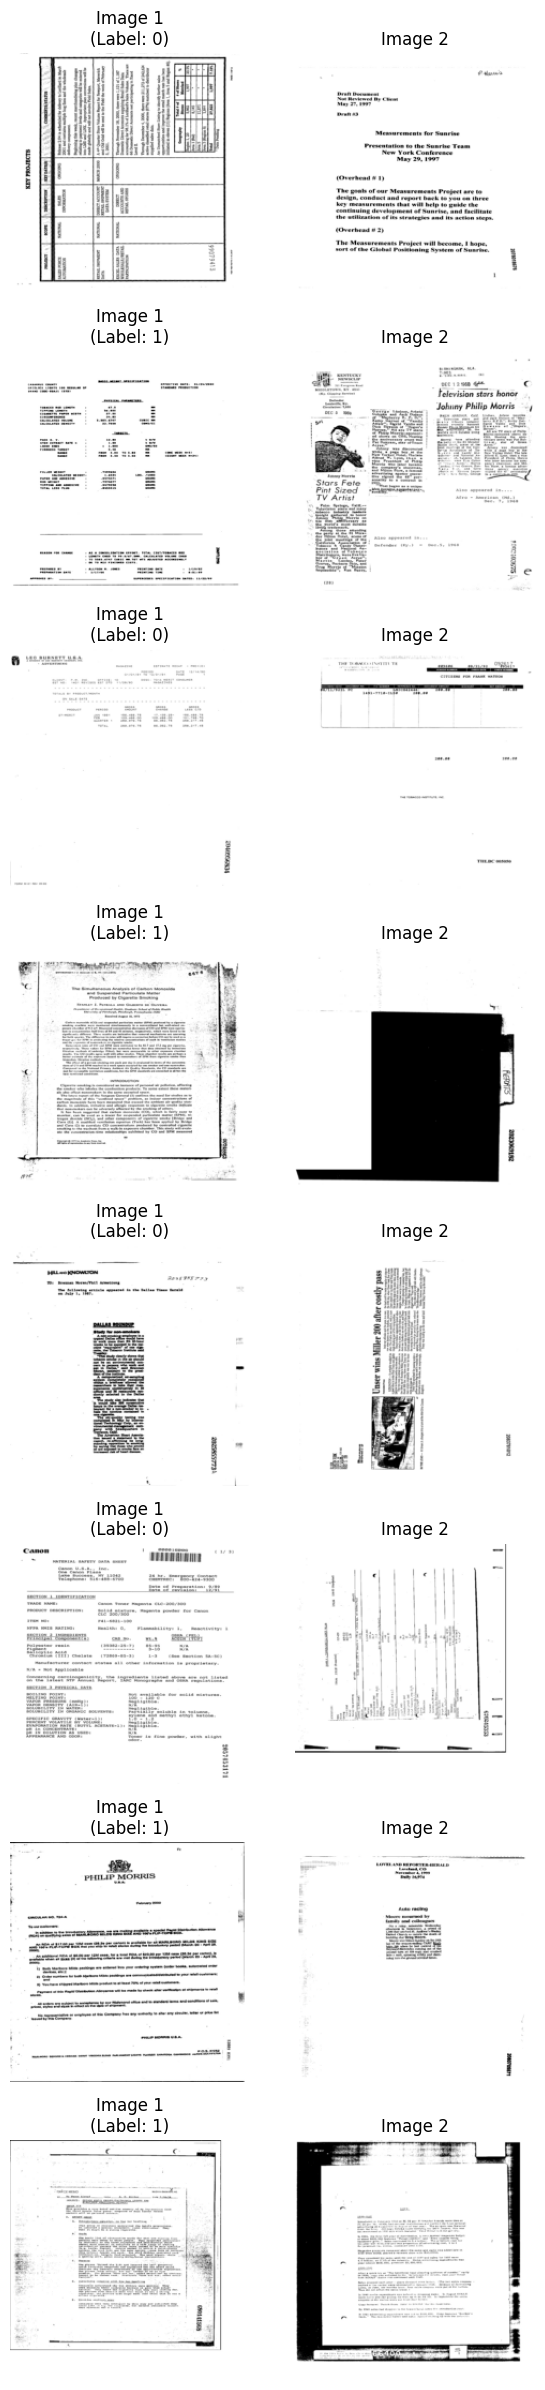

In [12]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_dataloader))

images1, images2, labels, paths1, paths2, class_labels1, class_labels2 = sample_batch

# Plot the 8 pairs
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(6, 24))  # 8 pairs, 2 images each

for i in range(8):
    img1 = images1[i].squeeze().numpy()
    img2 = images2[i].squeeze().numpy()
    label = labels[i].item()

    # Print information for each pair
    print(f"Pair {i + 1}")
    print(f"Image 1 Path: {paths1[i]}")
    print(f"Image 2 Path: {paths2[i]}")
    print(f"Same class (0) or different (1): {label}")
    print(f"Image 1 Class Label: {class_labels1[i]} (in words: {class_names[int(class_labels1[i])]})")
    print(f"Image 2 Class Label: {class_labels2[i]} (in words: {class_names[int(class_labels2[i])]})")
    print("-" * 50)

    axes[i, 0].imshow(img1, cmap='gray')
    axes[i, 0].set_title(f'Image 1\n(Label: {label})')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(img2, cmap='gray')
    axes[i, 1].set_title('Image 2')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# building the model

In [13]:
import torch
import torch.nn as nn


class SiameseDocumentNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_size=(100, 100)):
        super(SiameseDocumentNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=11, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=7, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
        )

        with torch.inference_mode():
            dummy_input = torch.zeros(1, input_shape, *image_size)
            dummy_output = self.cnn(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),  # Final embedding size
        )

    def forward_once(self, x):
        output = self.cnn(x)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


## checking the models shapes
net = SiameseDocumentNetwork(input_shape=1,
                             hidden_units=16,
                             output_shape=len(class_names),
                             image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
sample_batch = next(iter(train_dataloader))

images1, images2, labels, paths1, paths2, class_labels1, class_labels2 = sample_batch
images1, images2 = net(images1, images2)
images1.shape, images2.shape


(torch.Size([16, 16]), torch.Size([16, 16]))

# loss function(s)

In [14]:
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # print(f"output1: {output1}, output2: {output2}, label: {label}")
        # Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# training

In [15]:
from torch.utils.data import DataLoader

HIDDEN_UNITS = 16
net = SiameseDocumentNetwork(input_shape=1,
                             hidden_units=HIDDEN_UNITS,
                             output_shape=len(class_names),
                             image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
criterion = ContrastiveLoss(margin=0.8)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

## training loop

In [16]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Training loop with tqdm progress bar
num_epochs = 1
num_batches = len(train_dataloader)

for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_start_time = timer()

    progress_bar = tqdm(train_dataloader, desc=f"Epoch (Train): {epoch + 1}/{num_epochs}")

    for i, (img0, img1, label, _, _, _, _) in enumerate(progress_bar):
        net.train()

        # Forward pass
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss tracking
        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

        # Epoch elapsed time
        epoch_elapsed = timer() - epoch_start_time
        epoch_elapsed_str = f"{int(epoch_elapsed // 60)}m {int(epoch_elapsed % 60)}s"

        progress_bar.set_postfix(
            avg_loss=f"{avg_loss:.4f}",
            epoch_elapsed=epoch_elapsed_str
        )

    # After each epoch, estimate remaining time and print summary
    epoch_elapsed = timer() - epoch_start_time
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = epoch_elapsed * (remaining_epochs + 1)  # plus one test run

    epoch_elapsed_str = f"{int(epoch_elapsed // 60)}m {int(epoch_elapsed % 60)}s" if epoch_elapsed >= 60 else f"{int(epoch_elapsed)}s"
    est_rem_str = f"{int(estimated_remaining_time // 60)}m {int(estimated_remaining_time % 60)}s" if estimated_remaining_time >= 60 else f"{int(estimated_remaining_time)}s"

    print(
        f"Epoch {epoch + 1}/{num_epochs} done — runtime: {epoch_elapsed_str}, estimated time remaining: {est_rem_str}")

# Testing phase
running_test_loss = 0.0
progress_bar_test = tqdm(test_dataloader, desc="Testing Stage", colour="gray")

for img0, img1, label, _, _, _, _ in progress_bar_test:
    net.eval()
    output1, output2 = net(img0, img1)
    test_loss = criterion(output1, output2, label)
    running_test_loss += test_loss.item()
    avg_test_loss = running_test_loss / (progress_bar_test.n + 1)
    progress_bar_test.set_postfix(avg_test_loss=f"{avg_test_loss:.4f}")


Epoch (Train): 1/1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/1 done — runtime: 4m 43s, estimated time remaining: 4m 43s


Testing Stage:   0%|          | 0/313 [00:00<?, ?it/s]

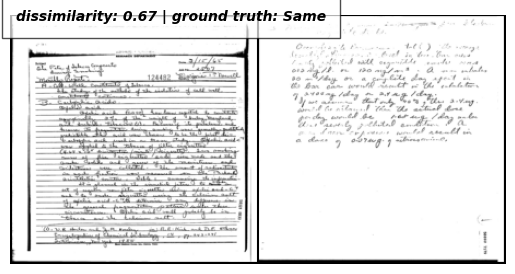

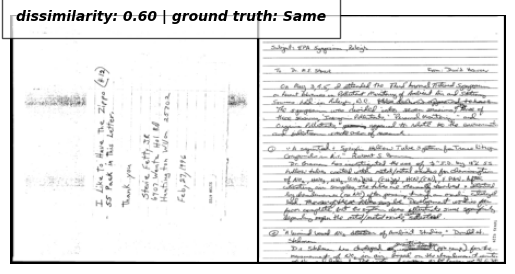

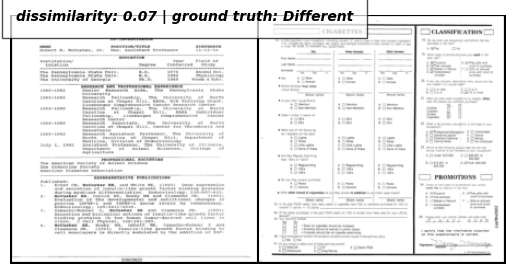

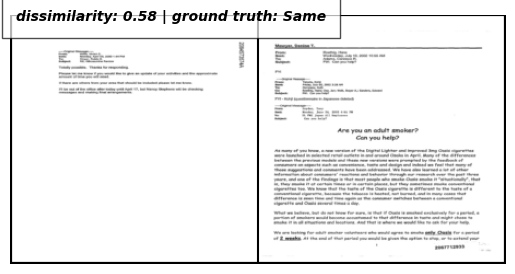

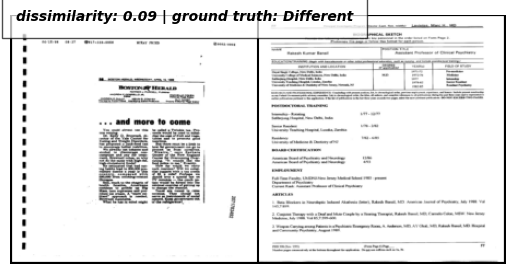

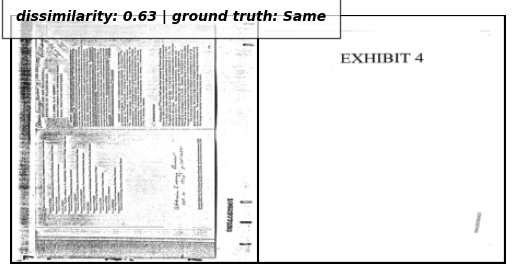

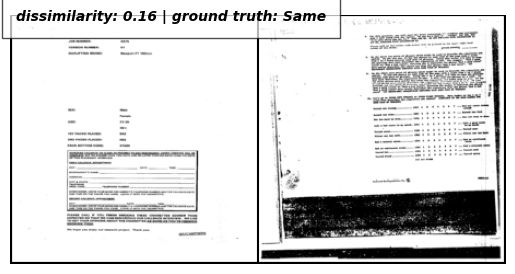

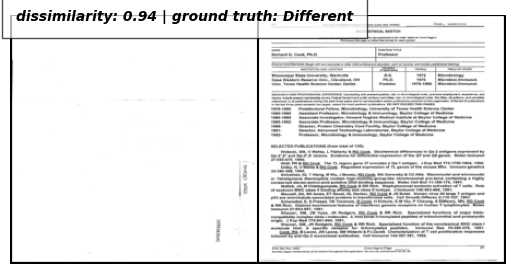

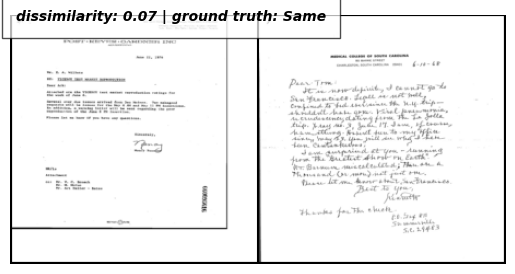

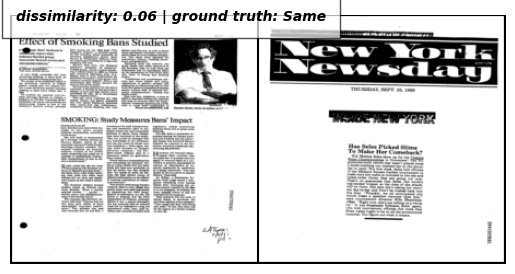

In [291]:
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np


def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(5, 5, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def evaluate_siamese_model(model, dataset, num_pairs=10):
    """
    Evaluate a Siamese network model by visualizing image pairs and their dissimilarity scores.

    Args:
        model (torch.nn.Module): The trained Siamese network.
        dataset (torch.utils.data.Dataset): Dataset returning image pairs and binary labels.
        num_pairs (int): Number of image pairs to evaluate and visualize.
    """

    model.eval()
    dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    for i, (img1, img2, pair_label, _, _, _, _) in enumerate(dataloader):
        if i >= num_pairs:
            break

        with torch.inference_mode():
            output1, output2 = model(img1, img2)
            distance = F.pairwise_distance(output1, output2).item()

        # Properly detach, squeeze, and prepare for display
        img1_cpu = img1.squeeze(0).cpu()
        img2_cpu = img2.squeeze(0).cpu()
        concatenated = make_grid([img1_cpu, img2_cpu], nrow=2)

        label_text = "Same" if pair_label.item() == 0 else "Different"
        imshow(concatenated, text=f"dissimilarity: {distance:.2f} | ground truth: {label_text}")


evaluate_siamese_model(net, test_dataset)


In [11]:
p = "data/RVL_CDIP/images\\imagese/e/j/e/eje42e00/2500126531_2500126536.tif"
q = "data/RVL_CDIP/images\\imagese/e/j/e/eje41e00/81440802.tif"
img = Image.open(p).convert("RGB")
plt.imshow(img)
img2 = Image.open(q).convert("RGB")
plt.imshow(img2)

C:\Users\lhuen\PycharmProjects\MNIST-SiameseNetwork\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


UnidentifiedImageError: cannot identify image file 'data/RVL_CDIP/images\\imagese/e/j/e/eje42e00/2500126531_2500126536.tif'